# NLP Portfolio Project: Sentiment Classification + Topic Modeling (Retail Reviews)

## Business Problem
You’re a marketing analytics team member at an e‑commerce retailer. Leadership wants:
1. **Always‑on sentiment tracking** of product reviews (by category, source, and over time).
2. **Drivers of sentiment** using topics/aspects (e.g., price, quality, delivery).
3. **Actionable dashboards**: category × week positive rate, top complaints, and example reviews.


In [5]:
# Imports
import pandas as pd
import numpy as np
import re, string
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (8,5)
pd.set_option('display.max_colwidth', 160)

In [6]:
# Load data
import pathlib

DATA_PATH = pathlib.Path('../') / '/content/reviews_nlp_synth.csv'
if not DATA_PATH.exists():
    DATA_PATH = pathlib.Path('reviews_nlp_synth.csv')  # Fallback if running from the same folder
df = pd.read_csv(DATA_PATH)
df.head(3)

,review_id,source,category,stars,sentiment_label,review_text,review_date
0,a3b7f4e8-c1ec-4a58-ba64-a29bfc198f98,Amazon,Apparel,3,0,"In summary, I works fine. The build was fine. The install was fine..",2024-11-23
1,3e0769f1-5364-49b2-9356-ff4a34188a5d,Amazon,Automotive,3,1,"Overall, I met expectations.!",2023-04-06
2,c5f725ed-8edc-4a69-8f61-38a38ad7e973,Yelp,Beauty,3,1,"From my experience, I as expected.!",2024-07-28


### Quick EDA
- Check class balance, star distribution, category/source coverage, and time span.

In [7]:
print('Rows:', len(df))
print(df['sentiment_label'].value_counts(normalize=True).rename({0:'neg',1:'pos'}))
df.groupby('category')['review_id'].count().sort_values(ascending=False).head(10)

Rows: 25000
sentiment_label
neg    0.55048
pos    0.44952
Name: proportion, dtype: float64


,review_id
category,
Grocery,2580
Toys & Games,2538
Pet Supplies,2528
Apparel,2511
Books,2490
Sports & Outdoors,2486
Home & Kitchen,2485
Electronics,2474
Beauty,2459


/tmp/ipython-input-2068777825.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  by_month = df.set_index('review_date').resample('M')['sentiment_label'].mean()


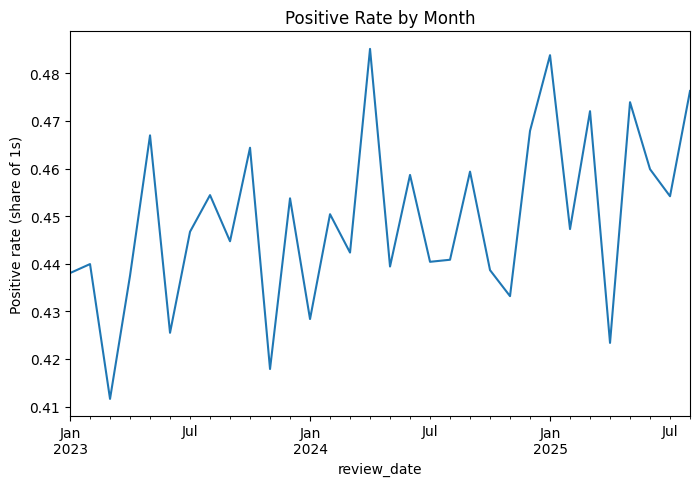

In [8]:
df['review_date'] = pd.to_datetime(df['review_date'])
by_month = df.set_index('review_date').resample('M')['sentiment_label'].mean()
ax = by_month.plot(title='Positive Rate by Month')
ax.set_ylabel('Positive rate (share of 1s)')
plt.show()

## Text Cleaning
Keep it simple and reproducible:
1. Lowercase
2. Strip punctuation
3. Collapse extra spaces
4. (Optional) Remove digits

We'll keep stopwords because linear models handle them well with regularization.

In [9]:
def clean_text(s: str):
    if pd.isna(s):
        return ''
    s = s.lower()
    s = re.sub(f'[{re.escape(string.punctuation)}]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['text_clean'] = df['review_text'].astype(str).apply(clean_text)
df[['review_text','text_clean']].head(3)

,review_text,text_clean
0,"In summary, I works fine. The build was fine. The install was fine..",in summary i works fine the build was fine the install was fine
1,"Overall, I met expectations.!",overall i met expectations
2,"From my experience, I as expected.!",from my experience i as expected


## Train/Validation/Test Split
Use 70/15/15 stratified split to evaluate generalization.

In [10]:
train, temp = train_test_split(df, test_size=0.30, stratify=df['sentiment_label'], random_state=123)
valid, test = train_test_split(temp, test_size=0.50, stratify=temp['sentiment_label'], random_state=123)
len(train), len(valid), len(test)

(17500, 3750, 3750)

## Baseline & Models
- **Baseline**: Majority class.
- **Model A**: Logistic Regression with TF‑IDF (word uni/bi‑grams).
- **Model B**: Linear SVM (LinearSVC) with TF‑IDF (word uni/bi‑grams).

In [11]:
baseline = train['sentiment_label'].value_counts(normalize=True).max()
print('Majority baseline accuracy:', round(baseline,4))

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)
logreg = LogisticRegression(max_iter=1000, n_jobs=None)
pipe_lr = Pipeline([
    ('tfidf', tfidf),
    ('clf', logreg)
])
pipe_lr.fit(train['text_clean'], train['sentiment_label'])

pred_v = pipe_lr.predict(valid['text_clean'])
proba_v = pipe_lr.predict_proba(valid['text_clean'])[:,1]
print(classification_report(valid['sentiment_label'], pred_v, digits=3))
print('ROC-AUC (valid):', roc_auc_score(valid['sentiment_label'], proba_v))

Majority baseline accuracy: 0.5505
              precision    recall  f1-score   support

           0      0.676     0.654     0.665      2064
           1      0.593     0.617     0.604      1686

    accuracy                          0.637      3750
   macro avg      0.634     0.635     0.635      3750
weighted avg      0.639     0.637     0.638      3750

ROC-AUC (valid): 0.7413697331880419


In [12]:
svm = LinearSVC()
pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    ('clf', svm)
])
pipe_svm.fit(train['text_clean'], train['sentiment_label'])
pred_v_svm = pipe_svm.predict(valid['text_clean'])
print(classification_report(valid['sentiment_label'], pred_v_svm, digits=3))

              precision    recall  f1-score   support

           0      0.681     0.648     0.664      2064
           1      0.593     0.628     0.610      1686

    accuracy                          0.639      3750
   macro avg      0.637     0.638     0.637      3750
weighted avg      0.642     0.639     0.640      3750



### ROC Curve for Logistic Regression
We plot ROC only for probabilistic model (LogReg).

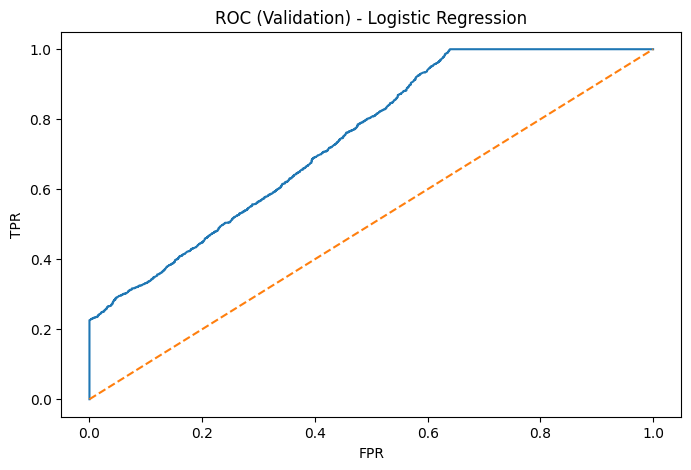

In [13]:
fpr, tpr, thr = roc_curve(valid['sentiment_label'], proba_v)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title('ROC (Validation) - Logistic Regression')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

## Error Analysis
Let's inspect the most confused examples to guide data rules and future feature work.

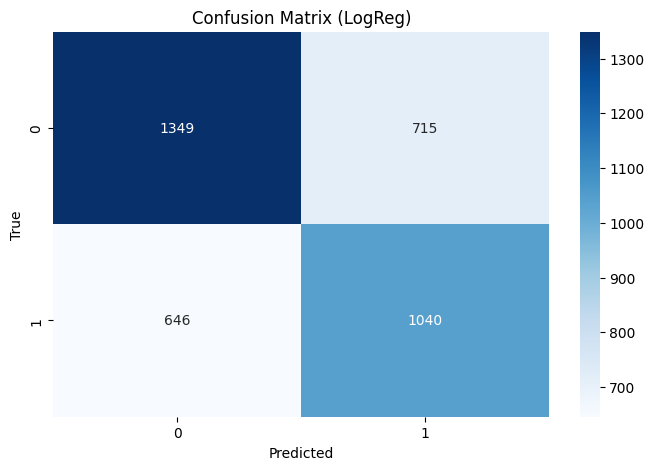

,review_text,sentiment_label,pred,proba_pos
11955,"Honestly, I does what it says. The setup was fine..",0,1,0.566016
17997,"In summary, I acceptable..",1,0,0.478892
13353,"After using it for a week, I decent overall. The cost was fine.!",0,1,0.508346
17999,"Overall, I met expectations. The agent was fine. The easy was fine..",1,0,0.494058
6692,"From my experience, I does what it says. The shipping was fine..",0,1,0.530747
23662,"After a month of use, I average quality. The help was fine.!",0,1,0.505175
2974,"Honestly, I nothing special. The delivery was fine.!!",1,0,0.458497
21116,"Overall, I acceptable. The setup was fine. The service was fine..",0,1,0.551064
15389,"From my experience, I okay for the price. The shipping was fine.!!",0,1,0.552752
20038,"After a month of use, I okay for the price. The support was fine. The price was fine.!!",1,0,0.437620


In [14]:
cm = confusion_matrix(valid['sentiment_label'], pred_v)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (LogReg)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

valid_err = valid.copy()
valid_err['pred'] = pred_v
valid_err['proba_pos'] = proba_v
errors = valid_err[valid_err['pred'] != valid_err['sentiment_label']]
errors[['review_text','sentiment_label','pred','proba_pos']].head(10)

## Explainability: Top Features
We show top n‑grams that push predictions toward positive vs negative.

In [15]:
tfidf_model = pipe_lr.named_steps['tfidf']
clf = pipe_lr.named_steps['clf']
feature_names = np.array(tfidf_model.get_feature_names_out())
coefs = clf.coef_[0]
top_pos_idx = np.argsort(coefs)[-20:]
top_neg_idx = np.argsort(coefs)[:20]
print('Top positive n-grams:')
print(feature_names[top_pos_idx])
print('\nTop negative n-grams:')
print(feature_names[top_neg_idx])

Top positive n-grams:
['buy' 'fantastic' 'fantastic buy' 'absolutely love' 'absolutely' 'love'
 'works perfectly' 'perfectly' 'five stars' 'five' 'stars'
 'exceeded expectations' 'exceeded' 'fast' 'fast delivery' 'satisfied'
 'very satisfied' 'well' 'was great' 'great']

Top negative n-grams:
['bad' 'was bad' 'overpriced' 'arrived late' 'confusing instructions'
 'disappointed' 'very disappointed' 'poor' 'poor quality' 'no'
 'no support' 'terrible' 'terrible experience' 'cheaply' 'made'
 'cheaply made' 'doesn' 'doesn work' 'work' 'stopped']


## Topic Modeling (LDA)
Unsupervised topics from raw text (train split).

In [16]:
cnt_vec = CountVectorizer(min_df=5, max_df=0.9, stop_words='english')
X_cnt = cnt_vec.fit_transform(train['text_clean'])
lda = LatentDirichletAllocation(n_components=8, random_state=123, learning_method='batch')
lda.fit(X_cnt)

def show_topics(model, feature_names, n_top_words=12):
    topics = []
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append((idx, top_features))
    return topics

topics = show_topics(lda, cnt_vec.get_feature_names_out())
for tid, words in topics:
    print(f'Topic {tid}:', ', '.join(words))

Topic 0: great, worth, using, week, fair, value, experience, easy, overall, honestly, perfectly, stars
Topic 1: bad, experience, using, week, support, fair, overall, summary, honestly, disappointed, cheaply, terrible
Topic 2: fine, price, does, says, okay, works, summary, using, week, fair, honestly, experience
Topic 3: use, month, fine, honestly, expected, expectations, met, acceptable, special, works, support, help
Topic 4: quality, fine, average, overall, fair, summary, week, using, honestly, experience, notch, poor
Topic 5: bad, defect, purchase, unhappy, set, hard, summary, stopped, working, delivery, overall, experience
Topic 6: fine, overall, decent, acceptable, expected, expectations, special, met, summary, fair, using, week
Topic 7: instructions, confusing, bad, arrived, broken, arrival, late, honestly, summary, overall, durable, fair


## Aspect-Level Sentiment (Lite)
We’ll use simple keyword dictionaries (price, quality, delivery, support, usability). For each review, if any keyword is present, we attribute the review’s predicted sentiment to that aspect and roll up by category/month.

In [17]:
aspect_to_keywords = {
    'price': ['price','cost','expensive','cheap','value','worth'],
    'quality': ['quality','build','durable','flimsy','premium','defect'],
    'delivery': ['delivery','shipping','arrived','late','courier','packaging'],
    'support': ['support','service','help','agent','rude','responsive'],
    'usability': ['setup','install','easy','confusing','instructions','manual'],
}

# Refit LR on train+valid for better generalization
pipe_lr.fit(pd.concat([train['text_clean'], valid['text_clean']]), pd.concat([train['sentiment_label'], valid['sentiment_label']]))

test_pred = pipe_lr.predict(test['text_clean'])
test_proba = pipe_lr.predict_proba(test['text_clean'])[:,1]
print('Test metrics (LogReg):')
print(classification_report(test['sentiment_label'], test_pred, digits=3))
print('ROC-AUC (test):', roc_auc_score(test['sentiment_label'], test_proba))

test_e = test[['review_id','review_text','text_clean','category','source','review_date']].copy()
test_e['pred'] = test_pred
test_e['proba_pos'] = test_proba

# Aspect tagging
def tag_aspects(text):
    found = []
    for asp, kws in aspect_to_keywords.items():
        for kw in kws:
            if f' {kw} ' in f' {text} ':
                found.append(asp)
                break
    return found

test_e['aspects'] = test_e['text_clean'].apply(tag_aspects)

# Explode aspects for aggregation
exploded = test_e.explode('aspects')
exploded['review_month'] = pd.to_datetime(exploded['review_date']).dt.to_period('M').dt.to_timestamp()
aspect_rollup = exploded.dropna(subset=['aspects']).groupby(['category','aspects','review_month'])['pred'].mean().reset_index()
aspect_rollup.rename(columns={'pred':'positive_rate'}, inplace=True)
aspect_rollup.head(10)

Test metrics (LogReg):
              precision    recall  f1-score   support

           0      0.691     0.648     0.669      2065
           1      0.599     0.644     0.621      1685

    accuracy                          0.646      3750
   macro avg      0.645     0.646     0.645      3750
weighted avg      0.649     0.646     0.647      3750

ROC-AUC (test): 0.7464373729172804


,category,aspects,review_month,positive_rate
0,Apparel,delivery,2023-01-01,0.500000
1,Apparel,delivery,2023-02-01,0.500000
2,Apparel,delivery,2023-03-01,0.500000
3,Apparel,delivery,2023-04-01,1.000000
4,Apparel,delivery,2023-05-01,0.000000
5,Apparel,delivery,2023-08-01,0.800000
6,Apparel,delivery,2023-11-01,0.333333
7,Apparel,delivery,2023-12-01,0.000000
8,Apparel,delivery,2024-02-01,0.000000
9,Apparel,delivery,2024-03-01,0.000000


## Output data files download
- `scores_test.csv`: per-review predictions
- `aspect_rollup.csv`: category × aspect × month positive rate
- `top_features.csv`: top positive/negative n‑grams for explainability

In [18]:
OUT_DIR = Path('outputs')
OUT_DIR.mkdir(exist_ok=True)

scores = test_e[['review_id','category','source','review_date','review_text','pred','proba_pos']]
scores.to_csv(OUT_DIR/'scores_test.csv', index=False)

aspect_rollup.to_csv(OUT_DIR/'aspect_rollup.csv', index=False)

import numpy as np
tfidf_model = pipe_lr.named_steps['tfidf']
clf = pipe_lr.named_steps['clf']
feature_names = np.array(tfidf_model.get_feature_names_out())
coefs = clf.coef_[0]

top_pos_idx = np.argsort(coefs)[-50:][::-1]
top_neg_idx = np.argsort(coefs)[:50]
feat_df = pd.DataFrame({
    'feature': list(feature_names[top_pos_idx]) + list(feature_names[top_neg_idx]),
    'coef': list(coefs[top_pos_idx]) + list(coefs[top_neg_idx])
})
feat_df.to_csv(OUT_DIR/'top_features.csv', index=False)
OUT_DIR, list(OUT_DIR.iterdir())

(PosixPath('outputs'),
 [PosixPath('outputs/scores_test.csv'),
  PosixPath('outputs/top_features.csv'),
  PosixPath('outputs/aspect_rollup.csv')])

## Next Steps
1. Enhance robustness using subword or character n-grams
To make the model more resilient to spelling variations, unseen words, and noisy user inputs, we’ll replace traditional word-level tokens with subword or character n-grams. This approach helps the model generalize better — for instance, it can still understand “loyaltee” as “loyalty” or handle partially unseen brand names.

2. Explore lightweight neural encoders (char CNN or tiny transformer)
Next, we’ll prototype a compact deep learning encoder — either a character-level CNN or a tiny transformer — depending on computational constraints. These architectures capture nuanced character patterns and contextual dependencies while keeping inference lightweight, ideal for deployment in production pipelines.

3. Introduce weak supervision to enrich training data
We’ll add weak labels generated from rule-based heuristics or keyword patterns (a form of distant supervision). These additional examples will help expand coverage in underrepresented classes and improve model generalization. After adding these pseudo-labeled samples, we’ll re-train and validate to ensure performance uplift.

4. Operationalize model scoring and automation
Finally, we’ll package the trained model into a REST API or batch scoring script for integration with downstream systems. A scheduler (e.g., Airflow, Azure Data Factory, or Cron) will trigger weekly refreshes — retraining or re-scoring on the latest data — ensuring the model remains up to date as inputs evolve.

## 🔥 Hugging Face Polarity Scoring

This section uses pre-trained transformers from Hugging Face to compute **polarity scores** for each review.

**Why**
- Model confidence as a continuous polarity score augments binary labels.
- Usually stronger at nuance vs. classical TF‑IDF models.

**Models**
- `distilbert-base-uncased-finetuned-sst-2-english` → 2-class POSITIVE/NEGATIVE
- `cardiffnlp/twitter-roberta-base-sentiment` → 3-class NEGATIVE/NEUTRAL/POSITIVE
- `nlptown/bert-base-multilingual-uncased-sentiment` → 1–5 stars

> ⚠️ Note: First run will download weights. If you're offline, skip execution or pre-cache models.


In [22]:
# Install (run once per environment)
import sys, subprocess, pkgutil

def pip_install(pkgs):
    for p in pkgs:
        # Split package name from version specifier
        package_name = p.split('==')[0].split('>')[0].split('<')[0].split('~')[0]
        if pkgutil.find_loader(package_name) is None:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', p, '-q'])

pip_install(['transformers>=4.40.0','torch'])

/tmp/ipython-input-3932139563.py:8: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader(package_name) is None:


In [38]:
from transformers import pipeline
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Choose a model: 'distilbert-base-uncased-finetuned-sst-2-english' or 'cardiffnlp/twitter-roberta-base-sentiment'
HF_MODEL = 'distilbert-base-uncased-finetuned-sst-2-english'  # change if you want 3-class
hf_sent = pipeline('sentiment-analysis', model=HF_MODEL, top_k=None)

def score_batch(texts):
    # Returns list of dicts per text: {'hf_label':..., 'hf_score':..., 'hf_polarity':...}
    out = []
    if 'cardiffnlp' in HF_MODEL:
        # 3-class: NEGATIVE / NEUTRAL / POSITIVE
        res = hf_sent(texts, return_all_scores=True, truncation=True)
        for text_results in res: # Iterate through results for each text in the batch
            scores = {}
            for d in text_results: # Iterate through the list of dictionaries for the current text
                # Normalize label names
                label = d['label'].upper()
                # some models use 'LABEL_0/1/2'; try to map if present
                if 'LABEL_0' in label:
                    # cardiff mapping: LABEL_0=NEGATIVE, LABEL_1=NEUTRAL, LABEL_2=POSITIVE
                    if label == 'LABEL_0': label = 'NEGATIVE'
                    elif label == 'LABEL_1': label = 'NEUTRAL'
                    elif label == 'LABEL_2': label = 'POSITIVE'
                scores[label] = d['score']

            label = max(scores, key=scores.get)
            # Signed polarity: positive prob - negative prob (ignoring neutral)
            polarity = float(scores.get('POSITIVE',0.0) - scores.get('NEGATIVE',0.0))
            conf = float(scores[label])
            out.append({'hf_label': label, 'hf_score': conf, 'hf_polarity': polarity})
    else:
        # 2-class
        res = hf_sent(texts, truncation=True)
        for text_result in res: # Iterate through results for each text in the batch
            # For 2-class, the inner list has only one dictionary
            r = text_result[0]
            label = r['label'].upper()
            score = float(r['score'])
            polarity = score if label == 'POSITIVE' else -score
            out.append({'hf_label': label, 'hf_score': score, 'hf_polarity': polarity})
    return out

def batched_apply(texts, batch_size=64):
    recs = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size].tolist()
        recs.extend(score_batch(batch))
    return pd.DataFrame(recs)

Device set to use cpu


In [39]:
# Score the TEST split to compare apples-to-apples with classical models
texts = test['review_text'].astype(str).reset_index(drop=True)
hf_df = batched_apply(texts, batch_size=64)
assert len(hf_df)==len(texts)

# Merge with test meta
test_reset = test.reset_index(drop=True)
test_hf = pd.concat([test_reset[['review_id','category','source','review_date','review_text','sentiment_label']], hf_df], axis=1)
test_hf.head(3)

  0%|          | 0/59 [00:00<?, ?it/s]

,review_id,category,source,review_date,review_text,sentiment_label,hf_label,hf_score,hf_polarity
0,f0446611-c4f6-40b8-9b55-7c4cbe8bfdbc,Pet Supplies,Amazon,2025-07-02,"From my experience, I overpriced..",0,NEGATIVE,0.997576,-0.997576
1,fcafb2ce-7302-45fb-938d-8ee077c55efd,Beauty,Amazon,2025-02-15,"After using it for a week, I as expected. The build was fine.!",1,POSITIVE,0.999540,0.999540
2,d1fae58f-6514-4827-ac38-a06be09baca1,Books,Newegg,2024-12-10,"To be fair, I unhappy with the purchase. The cost was bad..",0,NEGATIVE,0.999730,-0.999730


### Metrics & Comparison
- Convert HF labels to binary and compare with ground-truth.
- Plot ROC using `hf_polarity` → map (−1…+1) to (0…1) via `(x+1)/2`.

              precision    recall  f1-score   support

           0      0.920     0.400     0.557      2065
           1      0.565     0.957     0.711      1685

    accuracy                          0.650      3750
   macro avg      0.743     0.678     0.634      3750
weighted avg      0.761     0.650     0.626      3750

ROC-AUC (HF polarity): 0.7208739698665766


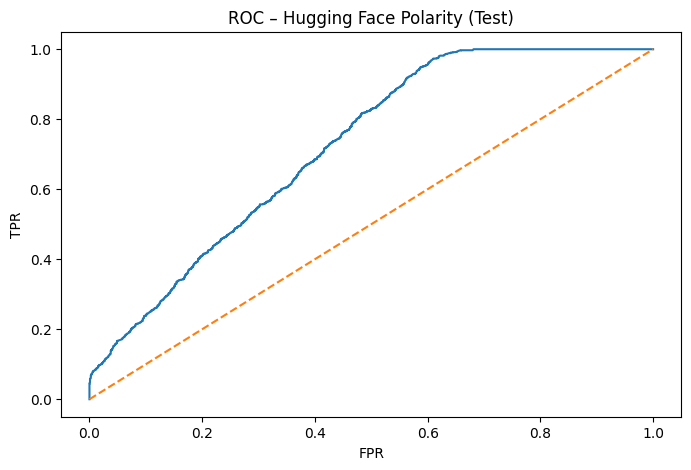

In [40]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def label_to_bin(lbl:str):
    if lbl is None:
        return np.nan
    l = str(lbl).upper()
    if 'POS' in l:
        return 1
    if 'NEG' in l:
        return 0
    # neutral → tie-break with polarity sign
    return np.nan

test_hf['hf_bin'] = test_hf['hf_label'].apply(label_to_bin)
mask = ~test_hf['hf_bin'].isna()
print(classification_report(test_hf.loc[mask,'sentiment_label'], test_hf.loc[mask,'hf_bin'], digits=3))

# ROC on continuous polarity
proba01 = (test_hf['hf_polarity'] + 1.0) / 2.0
print('ROC-AUC (HF polarity):', roc_auc_score(test_hf['sentiment_label'], proba01))
fpr, tpr, _ = roc_curve(test_hf['sentiment_label'], proba01)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title('ROC – Hugging Face Polarity (Test)')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.show()

### Export with HF Scores
- `outputs/scores_test_hf.csv` — test reviews with `hf_label`, `hf_score`, `hf_polarity`.
- `outputs/aspect_rollup_hf.csv` — category × aspect × month positive rate using HF labels.


In [43]:
OUT_DIR = Path('outputs'); OUT_DIR.mkdir(exist_ok=True)
test_hf.to_csv(OUT_DIR/'scores_test_hf.csv', index=False)

# Reuse aspect tagger from earlier cell if present; else redefine quickly
try:
    aspect_to_keywords
except NameError:
    aspect_to_keywords = {
        'price': ['price','cost','expensive','cheap','value','worth'],
        'quality': ['quality','build','durable','flimsy','premium','defect'],
        'delivery': ['delivery','shipping','arrived','late','courier','packaging'],
        'support': ['support','service','help','agent','rude','responsive'],
        'usability': ['setup','install','easy','confusing','instructions','manual'],
    }
def tag_aspects(text):
    t = ' ' + str(text).lower() + ' '
    found = []
    for asp, kws in aspect_to_keywords.items():
        if any((' ' + kw + ' ') in t for kw in kws):
            found.append(asp)
    return found

tmp = test_hf.copy()
tmp['aspects'] = tmp['review_text'].apply(tag_aspects)
tmp = tmp.explode('aspects').dropna(subset=['aspects'])
tmp['review_month'] = pd.to_datetime(tmp['review_date']).dt.to_period('M').dt.to_timestamp()

# Positive rate using HF labels (bin mapping)
tmp['hf_bin_fill'] = tmp['hf_bin']
tmp.loc[tmp['hf_label'].str.upper().eq('NEUTRAL'), 'hf_bin_fill'] = (tmp.loc[tmp['hf_label'].str.upper().eq('NEUTRAL'),'hf_polarity'] > 0).astype(int)

roll_hf = tmp.groupby(['category','aspects','review_month'])['hf_bin_fill'].mean().reset_index()
roll_hf.rename(columns={'hf_bin_fill':'positive_rate_hf'}, inplace=True)
roll_hf.to_csv(OUT_DIR/'aspect_rollup_hf.csv', index=False)
OUT_DIR, sorted([p.name for p in OUT_DIR.iterdir()])

(PosixPath('outputs'),
 ['aspect_rollup.csv',
  'aspect_rollup_hf.csv',
  'scores_test.csv',
  'scores_test_hf.csv',
  'top_features.csv'])